In [206]:
#Importing the clean dataset that was exported from Databricks because of environment problems, 
#the pre-processing continued here before the model implementation was also conducted

In [1]:
import pandas as pd

#Starting another Spark session, this time locally specific for the modeling
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ds_a24eliak_modeling').getOrCreate()

In [5]:
df_modeling = spark.read.csv(r'C:\Users\WhyWh\Downloads\a24_eliak\ds_a24eliak_clean.csv', header = True, inferSchema = True)

In [7]:
df_modeling.printSchema()

root
 |-- adv_day: integer (nullable = true)
 |-- weighted_class: double (nullable = true)
 |-- label_punctuality: integer (nullable = true)
 |-- train_owner_MTRX: double (nullable = true)
 |-- train_owner_Other: double (nullable = true)
 |-- train_owner_SJ: double (nullable = true)
 |-- train_owner_TÅGAB: double (nullable = true)
 |-- train_owner_VASTTRAF: double (nullable = true)
 |-- train_owner_VY: double (nullable = true)
 |-- train_owner_Ö-TÅG: double (nullable = true)
 |-- location_Alingsas: double (nullable = true)
 |-- location_Boras: double (nullable = true)
 |-- location_Falkoping: double (nullable = true)
 |-- location_Gothenburg: double (nullable = true)
 |-- location_Molndal: double (nullable = true)
 |-- location_Other: double (nullable = true)
 |-- location_Skovde: double (nullable = true)
 |-- location_Trollhattan: double (nullable = true)
 |-- location_Uddevalla: double (nullable = true)
 |-- location_Vanersborg: double (nullable = true)
 |-- deviation_code_ANA003: do

In [11]:
from pyspark.ml.feature import VectorAssembler

#Combining multiple columns except the target variable, where these are features
feature_cols = [c for c in df_modeling.columns if c not in ['label_punctuality', 'weighted_class']]

#Combining all the features into one column of features
assembler = VectorAssembler(inputCols = feature_cols, outputCol = 'features')

#Transforming and keeping only the features, and label_punctuality as the target
df_final = assembler.transform(df_modeling).select('features', 'label_punctuality', 'weighted_class')

**TRAIN, TEST, SPLIT DATA**

In [13]:
#Train, test and splitting the data before implementing the models
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed = 30)

# Modeling

In [283]:
#Implementing the different classification models

**LOGISTIC REGRESSION**

In [15]:
from pyspark.ml.classification import LogisticRegression

In [17]:
lrc = LogisticRegression(featuresCol = 'features', 
                         labelCol = 'label_punctuality',
                         weightCol = 'weighted_class',
                         maxIter = 50)

In [19]:
lrc_model = lrc.fit(train_df)

In [21]:
lrc_pred = lrc_model.transform(test_df)

**DECISION TREE**

In [23]:
from pyspark.ml.classification import DecisionTreeClassifier

In [25]:
dtc = DecisionTreeClassifier(featuresCol = 'features', 
                             labelCol = 'label_punctuality',
                             weightCol = 'weighted_class')

In [27]:
dtc_model = dtc.fit(train_df)

In [29]:
dtc_pred = dtc_model.transform(test_df)

**RANDOM FOREST**

In [31]:
from pyspark.ml.classification import RandomForestClassifier

In [33]:
rfc = RandomForestClassifier(featuresCol = 'features', 
                             labelCol = 'label_punctuality', 
                             weightCol = 'weighted_class',
                             numTrees = 50)

In [35]:
rfc_model = rfc.fit(train_df)

In [36]:
rfc_pred = rfc_model.transform(test_df)

**GBT**

In [39]:
from pyspark.ml.classification import GBTClassifier

In [41]:
gbtc = GBTClassifier(featuresCol = 'features', 
                     labelCol = 'label_punctuality', 
                     maxIter = 50)

In [43]:
gbtc_model = gbtc.fit(train_df)

In [45]:
gbtc_pred = gbtc_model.transform(test_df)

## Evaluation of model performance

In [218]:
#Evaluating the different models depending on the metrics

In [47]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

**ACCURACY**

In [49]:
evlt_accuracy = MulticlassClassificationEvaluator(labelCol = 'label_punctuality', 
                                                  predictionCol = 'prediction',
                                                  metricName = 'accuracy'
                                                 )

In [51]:
print('ACCURACY')
print('Logistic Regression: ', evlt_accuracy.evaluate(lrc_pred))
print('Decision Tree: ', evlt_accuracy.evaluate(dtc_pred))
print('Random Forest: ', evlt_accuracy.evaluate(rfc_pred))
print('GBT: ', evlt_accuracy.evaluate(gbtc_pred))

ACCURACY
Logistic Regression:  0.9748376623376623
Decision Tree:  0.983495670995671
Random Forest:  0.9402056277056277
GBT:  0.9867424242424242


**PRECISION**

In [53]:
evlt_precision = MulticlassClassificationEvaluator(labelCol = 'label_punctuality', 
                                         predictionCol = 'prediction',
                                         metricName = 'weightedPrecision'
                                                  )

In [55]:
print('PRECISION:')
print('Logistic Regression: ', evlt_precision.evaluate(lrc_pred))
print('Decision Tree: ', evlt_precision.evaluate(dtc_pred))
print('Random Forest: ', evlt_precision.evaluate(rfc_pred))
print('GBT: ', evlt_precision.evaluate(gbtc_pred))

PRECISION:
Logistic Regression:  0.9786117651700055
Decision Tree:  0.9853880846597012
Random Forest:  0.9593018072967495
GBT:  0.9872747214339193


**RECALL**

In [57]:
evlt_recall = MulticlassClassificationEvaluator(labelCol = 'label_punctuality', 
                                                predictionCol = 'prediction',
                                                metricName = 'weightedRecall'
                                                )

In [59]:
print('RECALL:')
print('Logistic Regression: ', evlt_recall.evaluate(lrc_pred))
print('Decision Tree: ', evlt_recall.evaluate(dtc_pred))
print('Random Forest: ', evlt_recall.evaluate(rfc_pred))
print('GBT: ', evlt_recall.evaluate(gbtc_pred))

RECALL:
Logistic Regression:  0.9748376623376623
Decision Tree:  0.983495670995671
Random Forest:  0.9402056277056278
GBT:  0.9867424242424243


**F1**

In [61]:
evlt_f1 = MulticlassClassificationEvaluator(labelCol = 'label_punctuality', 
                                            predictionCol = 'prediction',
                                            metricName = 'f1'
                                            )

In [65]:
print('F1-SCORE:')
print('Logistic Regression: ', evlt_f1.evaluate(lrc_pred))
print('Decision Tree: ', evlt_f1.evaluate(dtc_pred))
print('Random Forest: ', evlt_f1.evaluate(rfc_pred))
print('GBT: ', evlt_f1.evaluate(gbtc_pred))

F1-SCORE:
Logistic Regression:  0.975729356567477
Decision Tree:  0.9839187585398202
Random Forest:  0.9448261357320854
GBT:  0.9868992622514456


**ROC AUC**

In [67]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [69]:
evlt_roc_auc = BinaryClassificationEvaluator(labelCol = 'label_punctuality',
                                            rawPredictionCol = 'rawPrediction',
                                             metricName = 'areaUnderROC'
                                            )

In [71]:
print('ROC AUC: ')
print('Logistic Regression: ', evlt_roc_auc.evaluate(lrc_pred))
print('Decision Tree: ', evlt_roc_auc.evaluate(dtc_pred))
print('Random Forest: ', evlt_roc_auc.evaluate(rfc_pred))
print('GBT: ', evlt_roc_auc.evaluate(gbtc_pred))

ROC AUC: 
Logistic Regression:  0.9930650603202815
Decision Tree:  0.9901130696686911
Random Forest:  0.9887786171595977
GBT:  0.9970835596372554


## Evaluation and comparison of models

In [73]:
#Comparing all of the metrics for all the model in a overview:
print('__________________________________________')
print('#ACCURACY: ')
print('Logistic Regression: ', evlt_accuracy.evaluate(lrc_pred))
print('Decision Tree: ', evlt_accuracy.evaluate(dtc_pred))
print('Random Forest: ', evlt_accuracy.evaluate(rfc_pred))
print('GBT: ', evlt_accuracy.evaluate(gbtc_pred))
print('__________________________________________')
print('#PRECISION:')
print('Logistic Regression: ', evlt_precision.evaluate(lrc_pred))
print('Decision Tree: ', evlt_precision.evaluate(dtc_pred))
print('Random Forest: ', evlt_precision.evaluate(rfc_pred))
print('GBT: ', evlt_precision.evaluate(gbtc_pred))
print('__________________________________________')
print('#RECALL:')
print('Logistic Regression: ', evlt_recall.evaluate(lrc_pred))
print('Decision Tree: ', evlt_recall.evaluate(dtc_pred))
print('Random Forest: ', evlt_recall.evaluate(rfc_pred))
print('GBT: ', evlt_recall.evaluate(gbtc_pred))
print('__________________________________________')
print('#F1-SCORE:')
print('Logistic Regression: ', evlt_f1.evaluate(lrc_pred))
print('Decision Tree: ', evlt_f1.evaluate(dtc_pred))
print('Random Forest: ', evlt_f1.evaluate(rfc_pred))
print('GBT: ', evlt_f1.evaluate(gbtc_pred))
print('__________________________________________')
print('#ROC AUC: ')
print('Logistic Regression: ', evlt_roc_auc.evaluate(lrc_pred))
print('Decision Tree: ', evlt_roc_auc.evaluate(dtc_pred))
print('Random Forest: ', evlt_roc_auc.evaluate(rfc_pred))
print('GBT: ', evlt_roc_auc.evaluate(gbtc_pred))
print('__________________________________________')

__________________________________________
#ACCURACY: 
Logistic Regression:  0.9748376623376623
Decision Tree:  0.983495670995671
Random Forest:  0.9402056277056277
GBT:  0.9867424242424242
__________________________________________
#PRECISION:
Logistic Regression:  0.9786117651700055
Decision Tree:  0.9853880846597012
Random Forest:  0.9593018072967495
GBT:  0.9872747214339193
__________________________________________
#RECALL:
Logistic Regression:  0.9748376623376623
Decision Tree:  0.983495670995671
Random Forest:  0.9402056277056278
GBT:  0.9867424242424243
__________________________________________
#F1-SCORE:
Logistic Regression:  0.975729356567477
Decision Tree:  0.9839187585398202
Random Forest:  0.9448261357320854
GBT:  0.9868992622514456
__________________________________________
#ROC AUC: 
Logistic Regression:  0.9930650603202815
Decision Tree:  0.9901130696686911
Random Forest:  0.9887786171595977
GBT:  0.9970835596372554
__________________________________________


## Hyperparameter tuning

In [75]:
#Hyperparameter tuning the models to see if they could slightly improve a little bit even though
#the values are high for all the models

from pyspark.ml.tuning import ParamGridBuilder

In [77]:
#Logistic regression
param_grid_lrc = ParamGridBuilder().addGrid(lrc.regParam, [0.01, 0.1, 0.2])\
                                    .addGrid(lrc.elasticNetParam, [0, 0.01, 0.02, 0.05]).build()

In [79]:
#Decision tree
param_grid_dtc = ParamGridBuilder().addGrid(dtc.maxDepth, [3, 5, 7, 10])\
                                    .addGrid(dtc.minInstancesPerNode, [1, 3, 5]).build()

In [81]:
#Random forest
param_grid_rfc = ParamGridBuilder().addGrid(rfc.numTrees, [50, 100, 150])\
                                    .addGrid(rfc.maxDepth, [3, 5, 7, 10]).build()

In [83]:
#GBT
param_grid_gbtc = ParamGridBuilder().addGrid(gbtc.maxIter, [50, 70])\
                                    .addGrid(gbtc.maxDepth, [3, 5, 7]).build()

In [238]:
#Setting up the tuning by focusing on the ROC AUC as the evaluator since classes are imbalanced
#and by comparing the models afterwards, the best model will be chosen as the final one

In [85]:
from pyspark.ml.tuning import CrossValidator

In [87]:
#Logistic regression
cv_lrc = CrossValidator(estimator = lrc, evaluator = evlt_roc_auc, 
                        estimatorParamMaps = param_grid_lrc, numFolds = 3)

In [89]:
#Decision tree
cv_dtc = CrossValidator(estimator = dtc, evaluator = evlt_roc_auc, 
                        estimatorParamMaps = param_grid_dtc, numFolds = 3)

In [91]:
#Random forest
cv_rfc = CrossValidator(estimator = rfc, evaluator = evlt_roc_auc, 
                        estimatorParamMaps = param_grid_rfc, numFolds = 3)

In [93]:
#GBT
cv_gbtc = CrossValidator(estimator = gbtc, evaluator = evlt_roc_auc, parallelism = 2,
                        estimatorParamMaps = param_grid_gbtc, numFolds = 3)

In [ ]:
#Fitting the models

In [95]:
cv_lrc_model = cv_lrc.fit(train_df)
tuned_lrc = cv_lrc_model.bestModel

In [97]:
cv_dtc_model = cv_dtc.fit(train_df)
tuned_dtc = cv_dtc_model.bestModel

In [99]:
cv_rfc_model = cv_rfc.fit(train_df)
tuned_rfc = cv_rfc_model.bestModel

In [101]:
cv_gbtc_model = cv_gbtc.fit(train_df)
tuned_gbtc = cv_gbtc_model.bestModel

In [103]:
lrc_pred_cv = tuned_lrc.transform(test_df)

In [105]:
dtc_pred_cv = tuned_dtc.transform(test_df)

In [107]:
rfc_pred_cv = tuned_rfc.transform(test_df)

In [109]:
gbtc_pred_cv = tuned_gbtc.transform(test_df)

In [111]:
#Comparing the ROC AUC for the models before and after hyperparameter tuning
print('__________________________________________')
print('#ROC AUC: BEFORE TUNING')
print('Logistic Regression: ', evlt_roc_auc.evaluate(lrc_pred))
print('Decision Tree: ', evlt_roc_auc.evaluate(dtc_pred))
print('Random Forest: ', evlt_roc_auc.evaluate(rfc_pred))
print('GBT: ', evlt_roc_auc.evaluate(gbtc_pred))
print('__________________________________________')
print('#ROC AUC: AFTER TUNING')
print('Logistic Regression: ', evlt_roc_auc.evaluate(lrc_pred_cv))
print('Decision Tree: ', evlt_roc_auc.evaluate(dtc_pred_cv))
print('Random Forest: ', evlt_roc_auc.evaluate(rfc_pred_cv))
print('GBT: ', evlt_roc_auc.evaluate(gbtc_pred_cv))
print('__________________________________________')

__________________________________________
#ROC AUC: BEFORE TUNING
Logistic Regression:  0.9930650603202815
Decision Tree:  0.9901130696686911
Random Forest:  0.9887786171595977
GBT:  0.9970835596372554
__________________________________________
#ROC AUC: AFTER TUNING
Logistic Regression:  0.9899893019964112
Decision Tree:  0.9914090093648679
Random Forest:  0.9928323375960764
GBT:  0.997031550881351
__________________________________________


In [129]:
#Checking the best hyperparameter values for every model
#LOGISTIC REGRESSION
print('Logistic Regression')
print('regParam: ', tuned_lrc.getRegParam())
print('elasticNetParam: ', tuned_lrc.getElasticNetParam())
print('__________________________________________')

#DECISION TREE
print('Decision tree')
print('maxDepth: ', tuned_dtc.getMaxDepth())
print('minInstancesPerNode: ', tuned_dtc.getMinInstancesPerNode())
print('__________________________________________')

#RANDOM FOREST
print('Random forest')
print('numTrees: ', tuned_rfc.getNumTrees())
print('maxDepth: ', tuned_rfc.getMaxDepth())
print('__________________________________________')

#GBT
print('GBT')
print('maxIter: ', tuned_gbtc.getMaxIter())
print('maxDepth: ', tuned_gbtc.getMaxDepth())
print('__________________________________________')

Logistic Regression
regParam:  0.01
elasticNetParam:  0.05
__________________________________________
Decision tree
maxDepth:  10
minInstancesPerNode:  5
__________________________________________
Random forest
maxDepth:  10
__________________________________________
GBT
maxIter:  70
maxDepth:  5
__________________________________________


## Classification Report

In [180]:
#Checking the classification report to look through the different labels separately for the metrics
from sklearn.metrics import classification_report
import numpy as np

**LOGISTIC REGRESSION**

In [185]:
lrc_pd = tuned_lrc.transform(test_df).select('label_punctuality', 'probability').toPandas()

In [187]:
lrc_pd['probability_delayed'] = lrc_pd['probability'].apply(lambda x: x[0])

In [189]:
y_true_lbl_lrc = lrc_pd['label_punctuality'] 
y_score_probability_lrc = lrc_pd['probability_delayed']

In [191]:
y_pred_lrc = np.where(y_score_probability_lrc >= 0.5, 0, 1)

**DECISION TREE**

In [193]:
dtc_pd = tuned_dtc.transform(test_df).select('label_punctuality', 'probability').toPandas()

In [195]:
dtc_pd['probability_delayed'] = dtc_pd['probability'].apply(lambda x: x[0])

In [197]:
y_true_lbl_dtc = dtc_pd['label_punctuality'] 
y_score_probability_dtc = dtc_pd['probability_delayed']

In [199]:
y_pred_dtc = np.where(y_score_probability_dtc >= 0.5, 0, 1)

**RANDOM FOREST**

In [201]:
rfc_pd = tuned_rfc.transform(test_df).select('label_punctuality', 'probability').toPandas()

In [203]:
rfc_pd['probability_delayed'] = rfc_pd['probability'].apply(lambda x: x[0])

In [205]:
y_true_lbl_rfc = rfc_pd['label_punctuality'] 
y_score_probability_rfc = rfc_pd['probability_delayed']

In [207]:
y_pred_rfc = np.where(y_score_probability_rfc >= 0.5, 0, 1)

**GBT**

In [209]:
#Converting the Spark dataframe to Pandas in order to view the ROC curve, where the predictions
#are generated, 
gbtc_pd = tuned_gbtc.transform(test_df).select('label_punctuality', 'probability').toPandas()

In [211]:
#Selecting the first element which is the delayed ones within the probabilities, 
#since 0 is delayed and 1 is punctual
gbtc_pd['probability_delayed'] = gbtc_pd['probability'].apply(lambda x: x[0])

In [213]:
#Assigning the labels that are true for delayed and punctual, and also the probability that is predicted
y_true_lbl_gbtc = gbtc_pd['label_punctuality'] 
y_score_probability_gbtc = gbtc_pd['probability_delayed']

In [231]:
#Creating the predicted class, checking the condition, and the probability if it is over 0,5
y_pred_gbtc = np.where(y_score_probability_gbtc >= 0.5, 0, 1)

In [279]:
#LOGISTIC REGRESSION
print(f'Logistic Regression: \n {classification_report(y_true_lbl_lrc, y_pred_lrc, target_names = ['0: Delayed', '1: Punctual'])}')

Logistic Regression: 
               precision    recall  f1-score   support

  0: Delayed       1.00      0.88      0.94      3225
 1: Punctual       0.55      1.00      0.71       471

    accuracy                           0.89      3696
   macro avg       0.77      0.94      0.82      3696
weighted avg       0.94      0.89      0.91      3696



In [221]:
#DECISION TREE
print(f'Decision Tree: \n {classification_report(y_true_lbl_dtc, y_pred_dtc, target_names = ['0: Delayed', '1: Punctual'])}')

Decision Tree: 
               precision    recall  f1-score   support

  0: Delayed       1.00      0.98      0.99      3225
 1: Punctual       0.89      1.00      0.94       471

    accuracy                           0.98      3696
   macro avg       0.95      0.99      0.97      3696
weighted avg       0.99      0.98      0.98      3696



In [225]:
#RANDOM FOREST
print(f'Random Forest: \n {classification_report(y_true_lbl_rfc, y_pred_rfc, target_names = ['0: Delayed', '1: Punctual'])}')

Random Forest: 
               precision    recall  f1-score   support

  0: Delayed       1.00      0.98      0.99      3225
 1: Punctual       0.88      1.00      0.94       471

    accuracy                           0.98      3696
   macro avg       0.94      0.99      0.96      3696
weighted avg       0.98      0.98      0.98      3696



In [233]:
#GBT
print(f'GBT: \n {classification_report(y_true_lbl_gbtc, y_pred_gbtc, target_names = ['0: Delayed', '1: Punctual'])}')

GBT: 
               precision    recall  f1-score   support

  0: Delayed       1.00      0.99      0.99      3225
 1: Punctual       0.92      0.97      0.95       471

    accuracy                           0.99      3696
   macro avg       0.96      0.98      0.97      3696
weighted avg       0.99      0.99      0.99      3696



## ROC AUC

In [235]:
#All models performed with a best score, where only decimals differed them. In this case GBT has
#been chosen, whereas here, the ROC AUC is being plotted

In [145]:
from sklearn.metrics import roc_curve, auc

In [147]:
#Calculating the false positive rate, and the true positive rate, while assigning the label 
#for positive, and thereafter computing the ROC
fpr, tpr, _ = roc_curve(y_true_lbl_gbtc, y_score_probability_gbtc, pos_label = 0)
roc_auc = auc(fpr, tpr)

In [149]:
import matplotlib.pyplot as plt

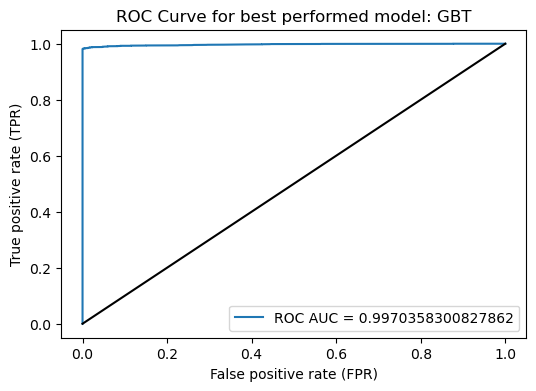

In [151]:
#Visualizing the ROC Curve for ROC AUC
plt.figure(figsize = (6,4))
plt.plot(fpr, tpr, label = f'ROC AUC = {roc_auc}')
plt.plot([0,1], [0,1], '-', color = 'black')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curve for best performed model: GBT')
plt.legend()
plt.show()

In [204]:
#Stopping Spark session
spark.stop()